# Multilevel Groundwater Flow with MLDA

### The MLDA sampler
This notebook (along with the utility code within the `./mlda` folder) is designed to demonstrate the Multi-Level Delayed Acceptance MCMC algorithm (MLDA) proposed in [1], as implemented within pymc3. 

The MLDA sampler can be more efficient than other MCMC samplers when dealing with computationally intensive problems where we have access not only to the desired (fine) posterior distribution but also to a set of approximate (coarse) posteriors of decreasing accuracy and decreasing computational cost. 

This is the case e.g. in subsurface flow models where a partial differential equation (PDE) with highly varying coefficients needs to be solved numerically on a fine spatial grid to perform each MCMC likelihood computation. If we have access to versions of the same model on coarser grids, we can apply a multilevel approach; in simple terms, we can use multiple chains on different coarseness levels and coarser chains' samples are used as proposals for the finer chains. This has been shown to improve the effective sample size of the finest chain and this allows us to reduce the number of expensive fine-chain likelihood evaluations.

For more details about the MLDA sampler and the way it should be used and parameterised, the user can refer to the code below, as well as the docstrings within the python code (the implementation is under `pymc3/pymc3/step_methods/metropolis.py`). A version of this code in .py form can be found under `./mlda`.

Please note that the MLDA sampler is new in pymc3. The user should be extra critical about the results and report any problems as issues in the pymc3's github repository.

The notebook results shown below were generated on a MacBook Pro with a 2.6 GHz 6-core Intel Core i7, 32 GB DDR4 and macOS 10.15.4.

### The model
Within this notebook, a simple MLDA sampler is compared to pymc3's Metropolis MCMC sampler. The target posterior is defined within the context of a Bayesian inverse problem for groundwater flow modeling, where we solve a PDE in each likelihood evaluation and we are able to do this in different coarseness levels.

The example demonstrates that MLDA is more efficient than Metropolis when measured by the Effective Samples per Second they can generate from the posterior. MLDA's relative efficiency becomes even larger when the size of the problem (i.e. fine resolution, number of parameters) increases. The user is encouraged to try different sizes, since the
ones used here are moderate to avoid long runtimes. Note that the likelihood in this example cannot be automatically differentiated therefore NUTS cannot be used.

### PDE solver details
The code within the `./mlda` folder solves the steady state groundwater flow problem for a random hydraulic conductivity field [2]. This solution acts as the forward model in the context of a Bayesian Inverse problem. In conjunction with MCMC, this setup allows for sampling from the posterior distribution of model parameters (hydraulic conductivity) given data (measurements of hydraulic head). This setup has applications in hydrogeological parameter estimation and uncertainty quantification. The forward model can work in differing levels of coarseness, allowing us to use a multilevel approach. 

Note that the solver uses "black box" code from an external C++ library (FEniCS [3]) which needs to be installed before running the notebook.

The files within `./mlda` contain the following:

`GwFlow.py`: This module is a FEniCS implementation of steady state groundwater flow in a confined aquifer, an elliptic Partial Differential Equation (PDE). It creates a mesh on a unit square domain, given the input resolution, imposes fixed head boundary conditions of 1 and 0 at left and right boundaries, respectively, and no-flow boundary conditions at the top and bottom boundaries. It then solves the problem given some FEniCS [3] function, representative of heterogeneous, isotropic hydraulic conductivity.

`RandomProcess.py`: This module generates realisations of a Gaussian Random Field with a squared exponential covariance function, as described in [2], representative of the (unknown) aquifer conductivity field. It takes a n x d matrix of nodal coordinates, a covariance length scale and a truncation parameter k, and computes the k largest Karhunen–Loève (KL) eigenmodes of the covariance matrix. It then generates random field realisations according to the mean and standard deviation of the desired log-conductivity field and a vector of random parameters.

`Model.py`: A module that wraps the groundwater flow solver and random process into one object. When the solve-method is called, it will solve the groundwater flow problem given a vector of random field parameters. The user can then extract hydraulic heads at datapoints using the get_data-method.


### Dependencies
The code has been developed and tested with Python 3.6. You will need to have pymc3 installed and also install [FEniCS](https://fenicsproject.org/) for your system.
  

### References
[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X

[2] Scarth, C., Adhikari, S., Cabral, P. H., Silva, G. H. C., & Prado, A. P. do. (2019). Random field simulation over curved surfaces: Applications to computational structural mechanics. Computer Methods in Applied Mechanics and Engineering, 345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026

[3] The FEniCS Project Version 1.5 M. S. Alnaes, J. Blechta, J. Hake, A. Johansson, B. Kehlet, A. Logg, C. Richardson, J. Ring, M. E. Rognes and G. N. Wells, Archive of Numerical Software, vol. 3, 2015


### Import modules

In [1]:
# Import groundwater flow model utils
import sys
sys.path.insert(1, 'mlda/')

In [2]:
import os
import numpy as np
import time
import pymc3 as pm
import theano.tensor as tt
from Model import Model, model_wrapper, project_eigenpairs
from itertools import product
import matplotlib.pyplot as plt
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Set environmental variable
%matplotlib inline

### Set parameters

In [3]:
# Set the resolution of the multi-level models (from coarsest to finest)
# This is a list of different model resolutions. Each
# resolution added to the list will add one level to the multi-level
# inference. Each element is a tuple (x,y) where x, y are the number of 
# points in each dimension. For example, here we set resolutions = 
# [(30, 30), (120, 120)] which creates a coarse, cheap 30x30 model and 
# a fine, expensive 120x120 model.
resolutions = [(30, 30), (120, 120)]

# Set random field parameters
field_mean = 0
field_stdev = 1
lamb_cov = 0.1

# Set the number of unknown parameters (i.e. dimension of theta in posterior)
nparam = 3

# Number of draws from the distribution
ndraws = 1000

# Number of burn-in samples
nburn = 500

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 4

# Subsampling rate for MLDA
nsub = 5

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = True

# Set the sigma for inference
sigma = 0.01

# Data generation seed
data_seed = 12345

# Sampling seed
sampling_seed = 12345

# Datapoints list
points_list = [0.1, 0.3, 0.5, 0.7, 0.9]

### Define the likelihood

In [4]:
# Use a Theano Op along with the code within ./mlda to construct the likelihood

def my_loglik(my_model, theta, datapoints, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    output = model_wrapper(my_model, theta, datapoints)
    return - (0.5 / sigma ** 2) * np.sum((output - data) ** 2)

class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" fenics code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood


### Instantiate Model objects and data

In [5]:
# Note this can take several minutes for large resolutions
my_models = []
for r in resolutions:
    my_models.append(Model(r, field_mean, field_stdev, nparam, lamb_cov))

# Project eignevactors from fine model to all coarse models
for i in range(len(my_models[:-1])):
    project_eigenpairs(my_models[-1], my_models[i])

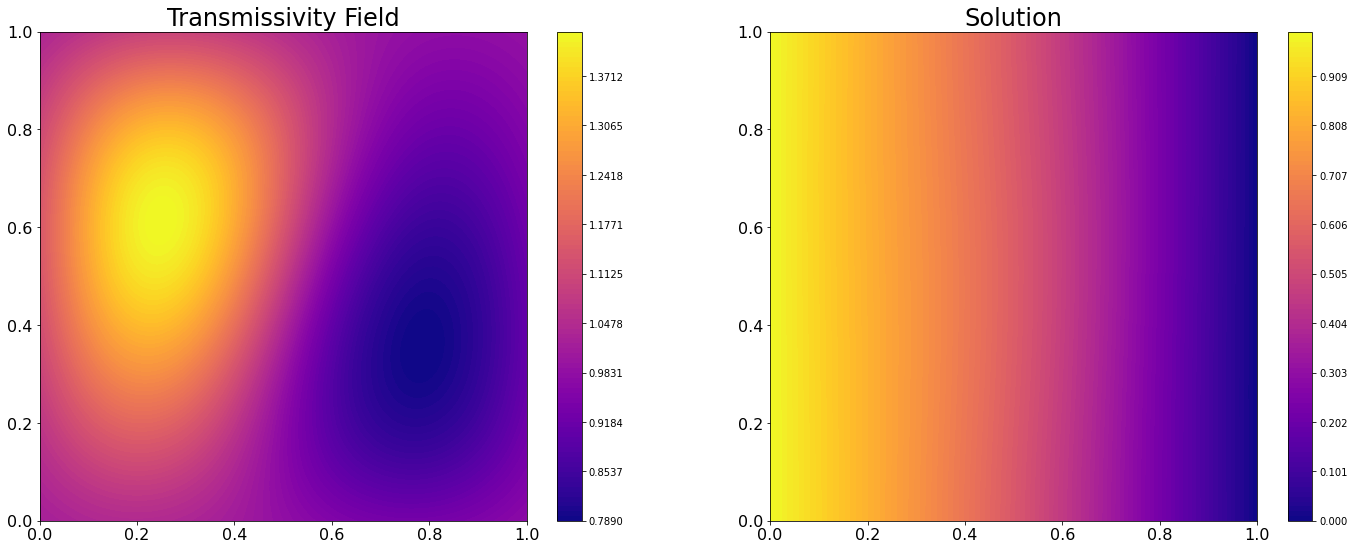

In [6]:
# Solve finest model as a test and plot transmissivity field and solution
np.random.seed(data_seed)
my_models[-1].solve()
my_models[-1].plot(lognormal=False)

# Save true parameters of finest model
true_parameters = my_models[-1].random_process.parameters

In [7]:
# Define the sampling points.
x_data = y_data = np.array(points_list)
datapoints = np.array(list(product(x_data, y_data)))

# Get data from the sampling points and perturb it with some noise.
noise = np.random.normal(0, 0.001, len(datapoints))

# Generate data from the finest model for use in pymc3 inference - these data are used in all levels
data = model_wrapper(my_models[-1], true_parameters, datapoints) + noise

### Instantiate LogLik objects

In [8]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for m in my_models:
    logl.append(LogLike(m, my_loglik, data, datapoints, sigma))

### Construct pymc3 model objects for coarse models

In [9]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # uniform priors on parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert m and c to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # use a DensityDist (use a lamdba function to "call" the Op)
        ll = logl[j]
        pm.DensityDist('likelihood', lambda v: ll(v), observed={'v': theta})

    coarse_models.append(model)


### Perform inference using MLDA and Metropolis

In [10]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

with pm.Model():
    # Uniform priors on parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # Convert m and c to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl[-1](v), observed={'v': theta})

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    # Also initialise a Metropolis step method object
    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked)
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, tune_interval=tune_interval, base_blocked=blocked)
    step_demetropolis = pm.DEMetropolis(tune='scaling', tune_interval=tune_interval)

    # Inference!
    # Metropolis
    t_start = time.time()
    method_names.append("Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_metropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    # MLDA
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(pm.sample(draws=ndraws, step=step_mlda,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    # DEMetropolis
    t_start = time.time()
    method_names.append("DEMetropolis")
    traces.append(pm.sample(draws=ndraws, step=step_demetropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)


/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:995: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta_2, theta_1, theta_0]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 489 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [theta_2, theta_1, theta_0]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 673 seconds.
The number of effective samples is smaller than 10% for some parameters.
Population sampling (4 chains)
DEMetropolis: [theta_2, theta_1, theta_0]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Population parallelization failed. Falling back to sequential stepping of chains.


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1306 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


### Print performance metrics

In [11]:
for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(pm.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')



Sampler Metropolis: 1000 drawn samples in each of 4 chains.
Runtime: 489.2367970943451 seconds
Acceptance rate: 0.28825
ESS list: [21.032503   57.11742444 55.4404015 ]
Normalised ESS list: [0.00525813 0.01427936 0.0138601 ]
ESS/sec: [0.04299044 0.11674801 0.11332018]

Sampler MLDA: 1000 drawn samples in each of 4 chains.
Runtime: 673.3848769664764 seconds
Acceptance rate: 0.99275
ESS list: [384.71755823 274.86532365 259.44235196]
Normalised ESS list: [0.09617939 0.06871633 0.06486059]
ESS/sec: [0.57131898 0.40818458 0.38528093]

Sampler DEMetropolis: 1000 drawn samples in each of 4 chains.
Runtime: 1306.5653102397919 seconds
Acceptance rate: 0.474
ESS list: [134.5357186  136.92215625 158.06065805]
Normalised ESS list: [0.03363393 0.03423054 0.03951516]
ESS/sec: [0.102969   0.10479549 0.12097417]


In [12]:
print(f"\nMLDA vs. Metropolis performance speedup in all dimensions (performance measured by ES/sec):\n{np.array(performances[1]) / np.array(performances[0])}")
print(f"\nMLDA vs. DEMetropolis performance speedup in all dimensions (performance measured by ES/sec):\n{np.array(performances[1]) / np.array(performances[2])}")


MLDA vs. Metropolis performance speedup in all dimensions (performance measured by ES/sec):
[13.28944377  3.49628715  3.39993224]

MLDA vs. DEMetropolis performance speedup in all dimensions (performance measured by ES/sec):
[5.5484563  3.89505853 3.18481971]


### Show stats summary

In [13]:
# Print true theta values and pymc3 sampling summary
print(f"\nDetailed summaries and plots:\nTrue parameters: {true_parameters}")
for i, trace in enumerate(traces):
    print(f"\nSampler {method_names[i]}:\n", pm.stats.summary(trace))


Detailed summaries and plots:
True parameters: [-0.20470766  0.47894334 -0.51943872]

Sampler Metropolis:
           mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta_0 -0.159  0.166  -0.432    0.160      0.037    0.027      20.0    20.0   
theta_1  0.475  0.107   0.289    0.705      0.014    0.010      58.0    56.0   
theta_2 -0.536  0.179  -0.890   -0.189      0.024    0.017      55.0    55.0   

         ess_bulk  ess_tail  r_hat  
theta_0      21.0      94.0   1.17  
theta_1      57.0     118.0   1.05  
theta_2      55.0     140.0   1.06  

Sampler MLDA:
           mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta_0 -0.197  0.172  -0.501    0.153      0.009    0.006     385.0   385.0   
theta_1  0.468  0.104   0.278    0.662      0.006    0.004     274.0   274.0   
theta_2 -0.549  0.174  -0.875   -0.230      0.011    0.008     259.0   259.0   

         ess_bulk  ess_tail  r_hat  
theta_0     385.0     612.0   1.01  
theta_1     

### Show traceplots

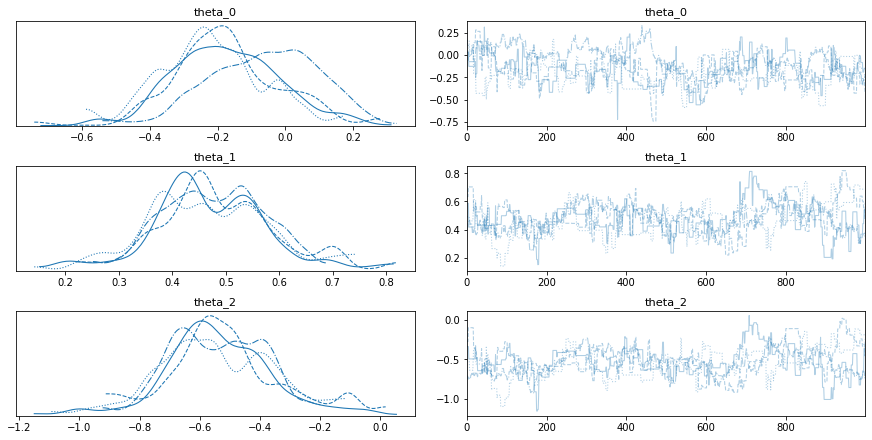

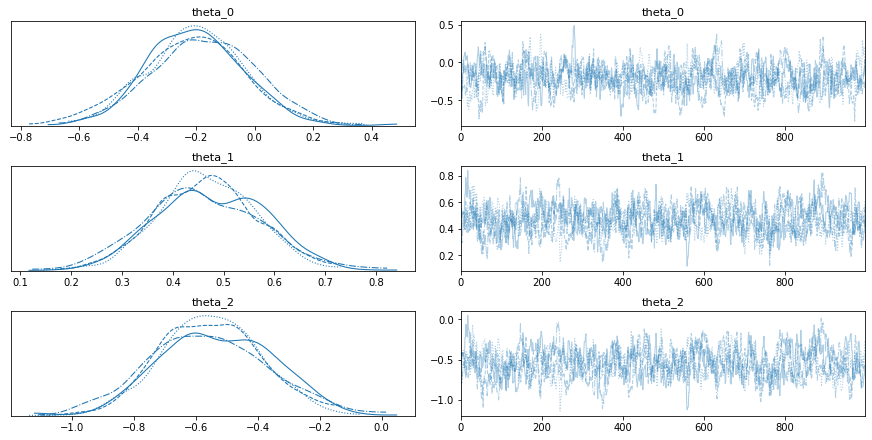

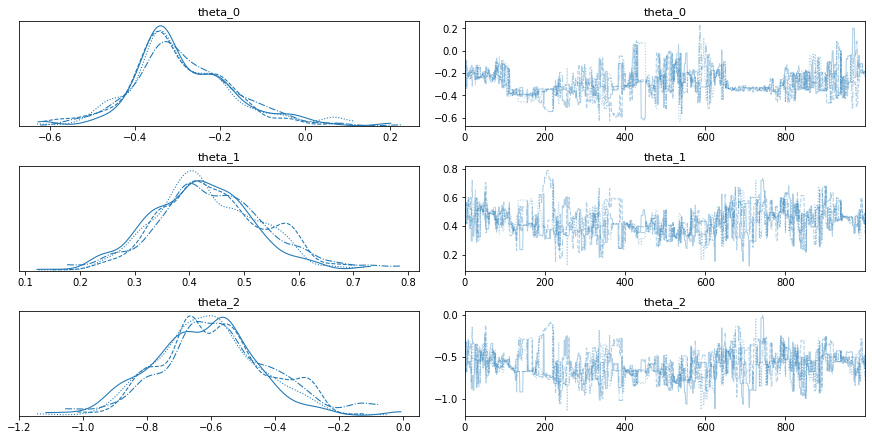

In [14]:
# Print true theta values and pymc3 sampling summary
for i, trace in enumerate(traces):
    pm.plots.traceplot(trace)
